<a href="https://colab.research.google.com/github/rjellis/densenet/blob/master/HW4_BIOE_245_SP2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOE 245 – Machine Learning in Medical Imaging 
####Homework 4

In this assignment you will build a complete deep learning pipeline. `testset.zip` (1.87GB) and `trainvalset.zip` (5.47GB) contain image data while `test_lab.csv` and `trainval_lab.csv` contain labels and demographic data. These are in a Box folder and will be downloaded directly into the Google Colab system in the scripts below. **The local google Colab filesystem gets deleted every 12ish hours, so you may need to rerun the scripts to redownload the data from Box if you leave the assignment and come back to it later.**

The goal of this assignment is to create a deep-learning model that will diagnose the presence and severity of radiographic osteoarthritis (KL) from cropped knee xray images. The dataset contains xrays of **one or both knees from 752 patients (565 patients in train/val, 187 patients in test) over several timepoints**. Each knee xray is evaluated by a radiologist and assigned a KL grade (from 0 to 4) which describes disease severity. The dataset we're working with is approximately 1/6th of the patients in the Osteoarthritis Initiative Dataset [ https://oai.epi-ucsf.org/datarelease/ ]. Distribution of KL grades is similar in trainval and testing sets.

KL | 0 | 1 | 2 | 3 | 4
--- | ---| ---| ---| ---| ---
 | no OA | doubtful OA | mild OA | moderate OA | severe OA

The easiest way to approach a new deep learning projects is doing it in parts:
1. Data download and characterization
2. Framing the learning problem
3. Network setup and training
4. Evaluation of results

(!!) Remember to activate GPUs by going to Runtime > Change Runtime Type and select GPU under Hardware Accelerator. Save checkpoints and download them frequently, as Colab runtime is not unlimited and training can time out.

---

<bt> Due date: Tuesday, June 1st, 11:59pm submission via Box upload. We will ask you to submit a pdf of your completed Google Colab notebook with printed outputs and a .h5 of your best performing model.


In [ ]:
# ONLY NEED TO RUN THIS ONCE, AT THE BEGINNING OF EACH RUNTIME
# MOVEMENT OF FILES BETWEEN BOX –> COLAB SHOULD TAKE AT MOST 10 MINUTES

!curl -L https://ucsf.box.com/shared/static/o6rvx2fihrdz1ptqd50tgqy008nqz7r2 -o 'trainval_lab.csv'
!curl -L https://ucsf.box.com/shared/static/iiqos0z8iqee96mqq6vhak4ldzv57rw0 -o 'test_lab.csv'

!curl -L https://ucsf.box.com/shared/static/uqsc0e733fu8lrjhicnrkmyjftyw3hml -o 'testset.zip'
!curl -L https://ucsf.box.com/shared/static/edsxwcg6x0iwr6kyo15q08y2jz8t2u0y -o 'trainvalset.zip'

# make directories and unzip both trainval_set.zip and test_set.zip
!mkdir trainval
!mkdir test

!unzip -qq trainvalset.zip -d 'trainval' 
!unzip -qq testset.zip -d 'test'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     6    0     6    0     0      4      0 --:--:--  0:00:01 --:--:--     4
100  423k  100  423k    0     0   194k      0  0:00:02  0:00:02 --:--:--  594k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:

In [12]:
# import the basic packages used throughout this assignment, 
# you are encouraged to import or pip install any other packages you might find useful
# (you can do this in a code cell by running !pip install my_package)

# NUMPY and visualization things
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import os

# TENSORFLOW things
%tensorflow_version 2.x
import tensorflow.compat.v2 as tf
#import tensorflow_datasets as tfds
import datetime
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

tf.keras.backend.clear_session() 

# handy function used later to read in .raw images from dataset
def load_im(im_path):
    raw_array = np.fromfile(im_path, dtype='float32')
    im = raw_array.reshape((500,500), order='C')
    im /= im.max()
    return im

### 1. Data download and characterization
Understand your dataset and labels, perform data cleaning if necessary. Your loaded in .csv files contain several variables.

 raw_file | ID | months | side | race | gender | age | BMI | **KL**
 --- | --- | --- | --- | --- | --- | --- | --- | ---
xray | anon patient ID | xray timepoint (TP) |left/right knee| race| male/female| `age @ TP | BMI @ TP | KL grade @ TP

<br>**Images**
>How many images are we working with in total? Are they 2D/3D? Multi-channel/single channel?
<br> Can you load in and plot a few images from the dataset?
<br> What does the intensity histogram of a few images look like? What range of values do these images contain? 
<br> What are "normal" variations in images? Are some flipped, rotated, inverted? Keep this in mind if you plan to implement augmentations in training.

<br> **Labels and demographics**
>What does the distribution of labels (KL) in the trainval dataset look like? How many observations are there per class?
<br> Does every image entry have a corresponding KL label?
<br> What are the demographics of this dataset? What is the mean age, BMI? What is the proportion of each race and gender?
<br> Is there an association between the demographic information and the KL label? 

(!!) These are notes and guiding questions (you do not need to provide answers)



In [2]:
# labels loaded into a pandas dataframe
# see https://www.datacourses.com/tips-for-performing-eda-with-python-671/ for 
# information on exploratory data analysis using Pandas

trainval_df = pd.read_csv('trainval_lab.csv')
trainval_df = trainval_df[trainval_df['KL'].notna()]

test_df = pd.read_csv('test_lab.csv')
test_df = test_df[test_df['KL'].notna()]

In [13]:
#see a sample of the data
test_df.sample(15)

,raw_file,ID,months,side,race,gender,age,BMI,KL
405,9368286_01_left_cropped.raw,9368286,12,left,1.0,1.0,75.0,28.1,0.0
1193,9438237_05_left_cropped.raw,9438237,36,left,1.0,1.0,74.0,28.5,3.0
674,9218935_01_right_cropped.raw,9218935,12,right,1.0,1.0,67.0,22.9,4.0
1366,9608737_05_right_cropped.raw,9608737,36,right,1.0,2.0,57.0,20.9,0.0
810,9794140_03_left_cropped.raw,9794140,24,left,1.0,2.0,48.0,23.6,0.0
1331,9143031_05_right_cropped.raw,9143031,36,right,1.0,1.0,53.0,25.6,0.0
1348,9407052_05_right_cropped.raw,9407052,36,right,1.0,2.0,80.0,27.9,3.0
708,9608737_01_right_cropped.raw,9608737,12,right,1.0,2.0,55.0,21.0,0.0
1758,9608137_08_left_cropped.raw,9608137,72,left,1.0,2.0,69.0,36.5,0.0
18,9281025_00_left_cropped.raw,9281025,0,left,1.0,2.0,57.0,20.1,1.0


shape of a single image (500, 500)


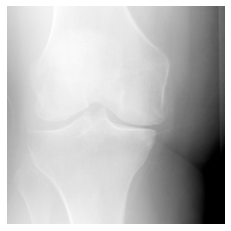

0.00015970037 1.0 0.7091682


In [14]:
sample_im = load_im('/content/trainval/'+trainval_df.raw_file[100])
print('shape of a single image', sample_im.shape)
plt.imshow(sample_im, cmap='gray')
plt.axis('off')
plt.show()
print(sample_im.min(), sample_im.max(), sample_im.mean())

{0.0, 1.0, 2.0, 3.0, 4.0}


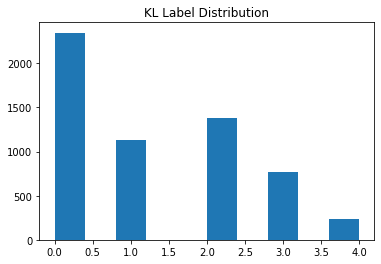

In [15]:
plt.figure()
plt.hist(trainval_df['KL'])
plt.title('KL Label Distribution')

print(set(trainval_df['KL'].dropna()))

### 2. Framing the learning problem
Create training and validation data splits (in the form of a `train_list` and a `validation_list`), choose type of deep-learning problem and an appropriate loss function. Use the lecture slides, Homework #3, and the convolutional_example.ipynb covered in class.

<br>**Splitting**
>Training and validation data is pooled so you'll need to define your own splitting heuristics. 
<br> Given that the dataset is large, would a random split be appropriate?
<br> Are there factors you need to account for when splitting the data? (Hint: compare total number of images against number of unique patients)
<br> Would you consider using a cross-validation scheme? How would you use this at test time?

<br>**Classification, Regression, or something else?**
>What type of learning problem can this be framed as? 
<br>What are the advantages/disadvantages of treating diagnosis as a classification problem? 
<br>What about a regression problem?
<br> What will the last network layer look like for each problem? What activation and loss functions?
<br> Reminder! Test data should not be touched until all experiments' training and validation are complete.

<br>**Auxilliary data**
>Is it possible that demographic data would improve the peformance of the network? How would you include this information? <br>Note: You are not expected to use the demographic data during training. 

(!!) These are notes and guiding questions (you do not need to provide answers)

In [16]:
subjects = list(set(trainval_df['ID']))
n = len(subjects)
n_split = int(n * 0.8)
train_subjects = subjects[:n_split]
val_subjects = subjects[n_split:]

print(len(train_subjects), len(val_subjects))
train_df = []
val_df = []
for idx, row in trainval_df.iterrows():
  if row['ID'] in train_subjects:
    train_df.append(row)
  elif row['ID'] in val_subjects:
    val_df.append(row)

train_df = pd.DataFrame(train_df, columns=test_df.columns)
val_df = pd.DataFrame(val_df, columns=test_df.columns)

452 113


There's ~10 images per subject in each split


### 3. Network setup and training

Build your dataloader, set up network architectures and choose callbacks (early stopping, saving, tensorboard, etc). You are expected to train at minimum two different architectures, but you're encouraged to try more.

**Network inputs**
> You can design custom architectures to accept any input size while off-the-shelf architectures (like MobileNetV2) may not support an arbitrary input size. 
<br> Have you made sure your input is sized correctly (height/width/channels) to be compatible with the architecture you chose?
<br> If you change your images to fit the input requirements for an off-the-shelf network, are the important imaging features still visible?
<br> How big are the imaging features in the knee dataset compared to the size of the convolutional kernels you are learning? 

**Model saving**
> Are you saving your outputs at regular intervals? (your last epoch may not be your best epoch) If epoch 30 gave you the best validation performance, but you trained until epoch 100, you need to have saved model weights early on.

**Bells and whistles**
> Start simple, overfit to your training data, then build in complexity. <br> Don't forget about the loss functions, optimizers, augmentations, and regularization strategies discussed in lecture.

(!!) These are notes and guiding questions (you do not need to provide answers)

In [17]:
# EXAMPLE
# we've built the test dataloader for you as an example, use a similar structure 
# to build your training and validation dataloaders

test_list = ('/content/test/'+test_df[~pd.isnull(test_df.KL)].raw_file).tolist()
train_list = ('/content/trainval/'+train_df[~pd.isnull(train_df.KL)].raw_file).tolist()
val_list = ('/content/trainval/'+val_df[~pd.isnull(val_df.KL)].raw_file).tolist()

def test_generator():
    for testfile in test_list:
        img = np.expand_dims(load_im(testfile),axis=2)
        raw_file = testfile.split('/')[-1]
        label = np.array(test_df[test_df.raw_file==raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int32, name='label')
        label = tf.squeeze(tf.one_hot(label, 4, on_value=1.0, off_value=0.0))
        yield img, label

def train_generator():
    for testfile in train_list:
        img = np.expand_dims(load_im(testfile),axis=2)
        raw_file = testfile.split('/')[-1]
        label = np.array(train_df[train_df.raw_file==raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int32, name='label')
        label = tf.squeeze(tf.one_hot(label, 4, on_value=1.0, off_value=0.0))
        yield img, label

def val_generator():
    for testfile in val_list:
        img = np.expand_dims(load_im(testfile),axis=2)
        raw_file = testfile.split('/')[-1]
        label = np.array(val_df[val_df.raw_file==raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int32, name='label')
        label = tf.squeeze(tf.one_hot(label, 4, on_value=1.0, off_value=0.0))
        yield img, label

def set_shapes(img, label, im_shape=(500,500,1)):
    img.set_shape(im_shape)
    label.set_shape(4)
    return img, label

# example augmentation function
def augment(img,label):
    img= tf.image.flip_left_right(img) 
    return img, label

ds_test = tf.data.Dataset.from_generator(test_generator, (tf.float32, tf.int16))
ds_test = ds_test.cache()
ds_test = ds_test.map(lambda img, label: set_shapes(img, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size=18)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# in training, shuffling would go after the .cache() line:
# ds_train = ds_train.shuffle(buffer_size=len(train_list))
ds_train = tf.data.Dataset.from_generator(train_generator, (tf.float32, tf.int16))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(buffer_size=len(train_list))
ds_train = ds_train.map(lambda img, label: set_shapes(img, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(batch_size=18)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = tf.data.Dataset.from_generator(val_generator, (tf.float32, tf.int16))
ds_val = ds_val.cache()
ds_val = ds_val.map(lambda img, label: set_shapes(img, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size=18)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

# preprocessing and/or augmentations (if training dataset) would go either after 
# the in the generator itself OR after the .map set_shapes line like so:
# ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Epoch 1/100
258/258 [==============================] - 18s 66ms/step - loss: 1.3029 - accuracy: 0.4296 - val_loss: 1.2757 - val_accuracy: 0.4843
Epoch 2/100
258/258 [==============================] - 17s 66ms/step - loss: 1.2764 - accuracy: 0.4298 - val_loss: 1.2440 - val_accuracy: 0.4843
Epoch 3/100
258/258 [==============================] - 17s 66ms/step - loss: 1.2677 - accuracy: 0.4298 - val_loss: 1.2334 - val_accuracy: 0.4843
Epoch 4/100
258/258 [==============================] - 17s 66ms/step - loss: 1.2654 - accuracy: 0.4298 - val_loss: 1.2286 - val_accuracy: 0.4843
Epoch 5/100
258/258 [==============================] - 17s 66ms/step - loss: 1.2645 - accuracy: 0.4298 - val_loss: 1.2294 - val_accuracy: 0.4843
Epoch 6/100
258/258 [==============================] - 17s 66ms/step - loss: 1.2640 - accuracy: 0.4298 - val_loss: 1.2272 - val_accuracy: 0.4843
Epoch 7/100
258/258 [==============================] - 17s 66ms/step - loss: 1.2635 - accuracy: 0.4298 - val_loss: 1.2263 - val_ac

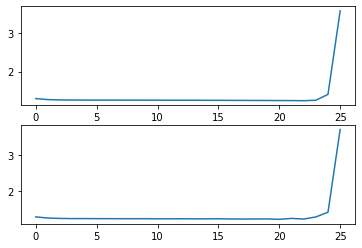

In [24]:
model_pool = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(4)
])

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model_pool.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=loss_fn,
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model_pool.fit(ds_train, validation_data=ds_val, epochs=100, callbacks=[callback])

fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')

Epoch 1/10
258/258 [==============================] - 10s 39ms/step - loss: 4669.2642 - accuracy: 0.3143 - val_loss: 91340.1953 - val_accuracy: 0.2351
Epoch 2/10
258/258 [==============================] - 10s 38ms/step - loss: 26770230.0000 - accuracy: 0.2841 - val_loss: 186941200.0000 - val_accuracy: 0.1109
Epoch 3/10
258/258 [==============================] - 10s 38ms/step - loss: 4117097984.0000 - accuracy: 0.2923 - val_loss: 28684838912.0000 - val_accuracy: 0.1697
Epoch 4/10
258/258 [==============================] - 10s 38ms/step - loss: 87589527552.0000 - accuracy: 0.2865 - val_loss: 109018791936.0000 - val_accuracy: 0.1697
Epoch 5/10
258/258 [==============================] - 10s 38ms/step - loss: 648589017088.0000 - accuracy: 0.2839 - val_loss: 1187065626624.0000 - val_accuracy: 0.1697
Epoch 6/10
258/258 [==============================] - 10s 38ms/step - loss: 3075779854336.0000 - accuracy: 0.2805 - val_loss: 8670925029376.0000 - val_accuracy: 0.4843
Epoch 7/10
258/258 [=======

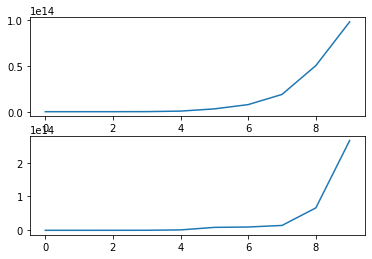

In [19]:
model_stride = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', strides=(2,2), activation='relu'),
  tf.keras.layers.Conv2D(16, 3, padding='same', strides=(2,2), activation='relu'),
  tf.keras.layers.Conv2D(16, 3, padding='same', strides=(2,2), activation='relu'),
  tf.keras.layers.Conv2D(16, 3, padding='same', strides=(2,2),  activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(4)
])

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model_stride.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=loss_fn,
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history2 = model_stride.fit(ds_train, validation_data=ds_val, epochs=100, callbacks=[callback])

fig, ax = plt.subplots(2, 1)
ax[0].plot(history2.history['loss'], label='Training Loss')
ax[1].plot(history2.history['val_loss'], label='Validation Loss')

### 4. Evaluation of results
Once you are happy with model performance on training/validation, evaluate each model on the test set using the test dataloader, modified with any custom preprocessing you might have implemented. 

**Print out the confusion matrix for each model** (you can use sklearn this time). If you posed the learning problem as a regression, go ahead and round the regression predictions to create class predictions. **Calculate the weighted kappa coefficient for each model** (also available in sklearn).

In [38]:
pred_pool = model_pool.predict(ds_test)
pred_pool = tf.nn.softmax(pred_pool)
pred_stride = model_pool.predict(ds_test)
pred_stride = tf.nn.softmax(pred_stride)

pred_pool = tf.argmax(pred_pool, axis=-1).numpy()
pred_stride = tf.argmax(pred_stride, axis=-1).numpy()


Text(0.5, 1.0, 'Distribution of pooling model predictions')

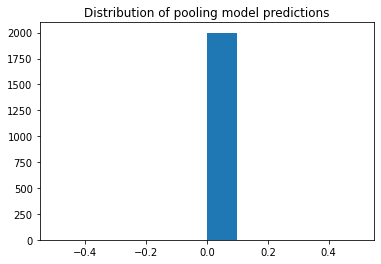

In [41]:
plt.hist(pred_pool)
plt.title("Distribution of pooling model predictions")

Text(0.5, 1.0, 'Distribution of striding model predictions')

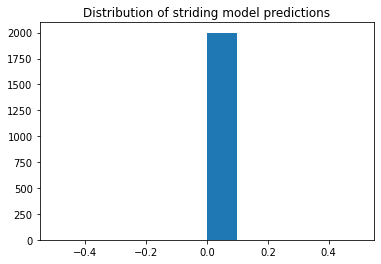

In [43]:
plt.hist(pred_stride)
plt.title("Distribution of striding model predictions")

In [56]:
from sklearn import metrics
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true = np.argmax(y_true, axis=-1)
cm_pool = metrics.confusion_matrix(y_true, pred_pool)
cm_stride = metrics.confusion_matrix(y_true, pred_stride)

print("Pooling model confusion matrix:")
print(cm_pool)
print("Striding model confusion matrix:")
print(cm_stride)
print(metrics.accuracy_score(y_true, pred_pool))
print(metrics.accuracy_score(y_true, pred_stride))

Pooling model confusion matrix:
[[880   0   0   0]
 [390   0   0   0]
 [513   0   0   0]
 [216   0   0   0]]
Striding model confusion matrix:
[[880   0   0   0]
 [390   0   0   0]
 [513   0   0   0]
 [216   0   0   0]]
0.44022011005502754
0.44022011005502754


In [54]:
weighted_kappa_pool = metrics.cohen_kappa_score(y_true, pred_pool)
weighted_kappa_stride = metrics.cohen_kappa_score(y_true, pred_stride)
print("pooling model kappa:", weighted_kappa_pool)
print("striding model kappa:", weighted_kappa_stride)

pooling model kappa: 0.0
striding model kappa: 0.0


Finally, answer these questions:
>1. Did your models perform similarly on the training, validation sets as they did on the final test set? If there were discrepancies, why do you think that is?

The model never learned to predict anything other than the first class, which is surprising given the simplicity of the model. The training loss diverges after 25 epochs 

>2. What strategies did you find most effective for improving the accuracy of diagnosis? Why?
Changing the optimizer from Adam to SGD was key to get the model to even train. The Adam optimizer for this model had exploding loss function even for very low learning rates while SGD was actually able to converge.

>3. Given unrestricted time and computational resources, list 4 suggestions you have for improving your models.

My models are very basic CNNs, mostly to get familiar with TensorFlow/Keras model training. If I had unlimited time I would try state of the art ImageNet models such as EfficientNet for transfer learning and fine tuning. It would be interesting to see if EfficientNet works as a feature extractor even though it was built for RGB data. I would also attempt to incorporate the demographic layer at the fully connected layer to see if it improves model performance. 